# Imports

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import conexion_db
import seaborn as sns
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.cm as cm

# 1. Usuarios que más cláusulas HAN HECHO (robado)

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1669652385.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_realizadas = pd.read_sql(query_realizadas, conn)


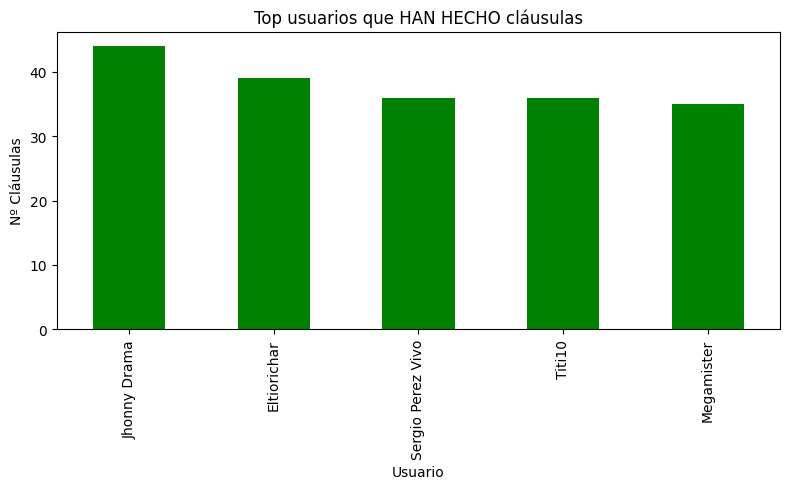

In [2]:
with conexion_db() as conn:
    query_realizadas = """
        SELECT usuario_destino AS usuario, COUNT(*) AS clausulas_realizadas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino
        ORDER BY clausulas_realizadas DESC
        LIMIT 5;
    """
    df_realizadas = pd.read_sql(query_realizadas, conn)

fig, ax = plt.subplots(figsize=(8, 5))
df_realizadas.plot(kind='bar', x='usuario', y='clausulas_realizadas', legend=False, ax=ax, color='green')
ax.set_title('Top usuarios que HAN HECHO cláusulas')
ax.set_xlabel('Usuario')
ax.set_ylabel('Nº Cláusulas')
plt.tight_layout()
plt.show()

 # 2. Usuarios que más cláusulas HAN SUFRIDO

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2937050547.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sufridas = pd.read_sql(query_sufridas, conn)


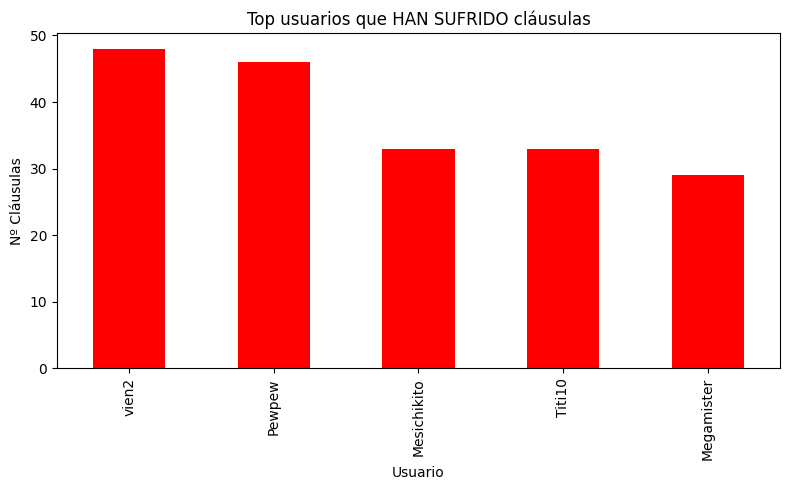

In [3]:
with conexion_db() as conn:
    query_sufridas = """
        SELECT usuario_origen AS usuario, COUNT(*) AS clausulas_sufridas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_origen
        ORDER BY clausulas_sufridas DESC
        LIMIT 5;
    """
    df_sufridas = pd.read_sql(query_sufridas, conn)

fig, ax = plt.subplots(figsize=(8, 5))
df_sufridas.plot(kind='bar', x='usuario', y='clausulas_sufridas', legend=False, ax=ax, color='red')
ax.set_title('Top usuarios que HAN SUFRIDO cláusulas')
ax.set_xlabel('Usuario')
ax.set_ylabel('Nº Cláusulas')
plt.tight_layout()
plt.show()

# 3. Tops robos entre usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1600032388.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_robos = pd.read_sql(query_robos, conn)


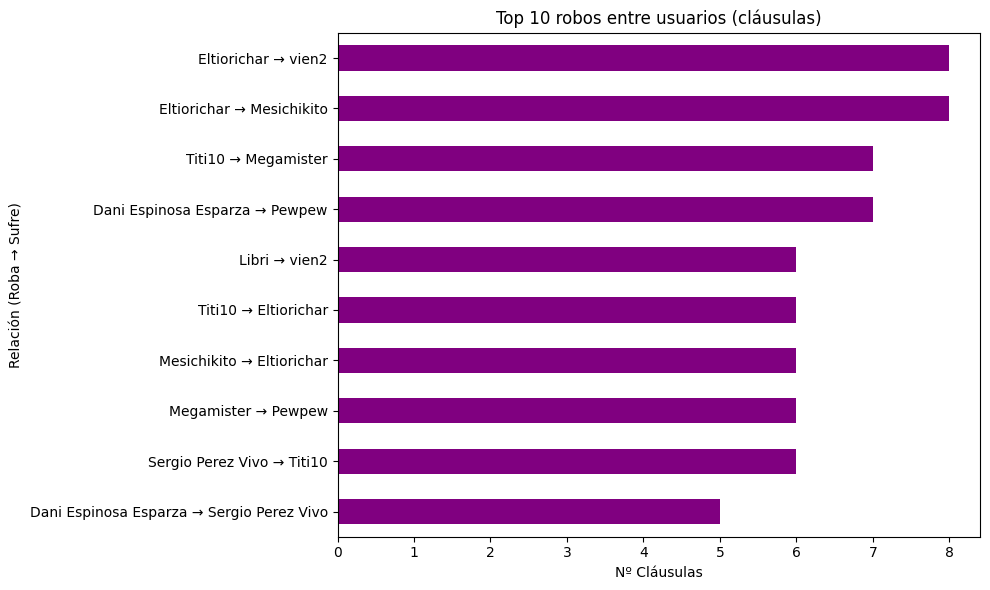

In [4]:
with conexion_db() as conn:
    query_robos = """
        SELECT 
            usuario_destino AS quien_roba,
            usuario_origen AS quien_sufre,
            COUNT(*) AS clausulas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino, usuario_origen
        ORDER BY clausulas DESC
        LIMIT 10;
    """
    df_robos = pd.read_sql(query_robos, conn)

# Crear una nueva columna para mostrar la relación
df_robos['relacion'] = df_robos['quien_roba'] + ' → ' + df_robos['quien_sufre']

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
df_robos.plot(kind='barh', x='relacion', y='clausulas', ax=ax, color='purple', legend=False)
ax.set_title('Top 10 robos entre usuarios (cláusulas)')
ax.set_xlabel('Nº Cláusulas')
ax.set_ylabel('Relación (Roba → Sufre)')
plt.gca().invert_yaxis()  # Para que el más alto aparezca arriba
plt.tight_layout()
plt.show()


# 4. HeatMap Robos entre usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2185274892.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


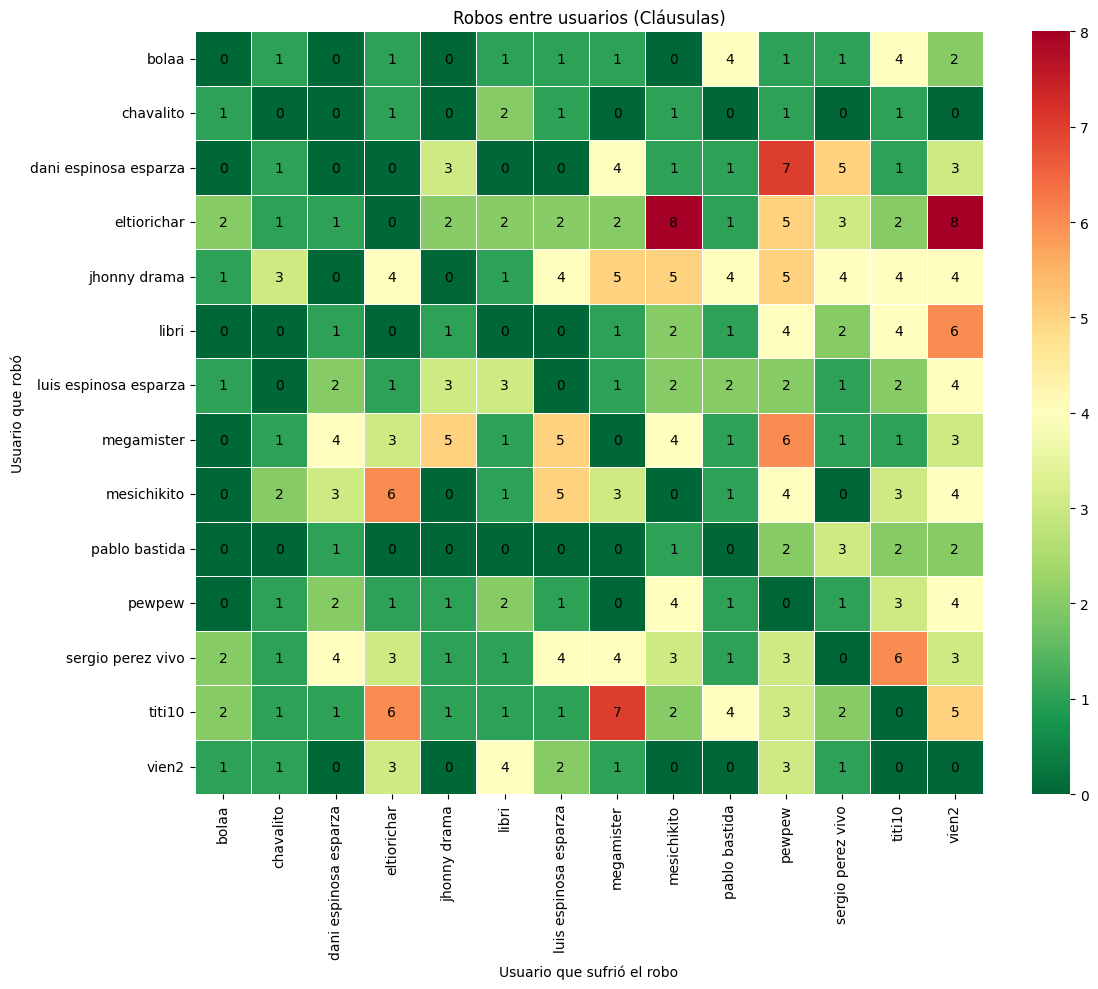

In [5]:
# 1. Cargar datos brutos
with conexion_db() as conn:
    query = """
        SELECT 
            usuario_destino AS quien_roba,
            usuario_origen AS quien_sufre,
            COUNT(*) AS clausulas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino, usuario_origen;
    """
    df_raw = pd.read_sql(query, conn)

# 2. Limpiar antes de agrupar
df_raw['quien_roba'] = df_raw['quien_roba'].str.strip().str.lower()
df_raw['quien_sufre'] = df_raw['quien_sufre'].str.strip().str.lower()

# 3. Re-agrupar (por si los nombres duplicados generaron filas separadas)
df = df_raw.groupby(['quien_roba', 'quien_sufre'], as_index=False).sum()

# 4. Crear la tabla pivote
pivot = df.pivot(index='quien_roba', columns='quien_sufre', values='clausulas').fillna(0)

# 5. Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".0f",
    cmap='RdYlGn_r',
    linewidths=0.5,
    cbar=True,
    annot_kws={"size": 10, "color": "black"}
)
plt.title("Robos entre usuarios (Cláusulas)")
plt.xlabel("Usuario que sufrió el robo")
plt.ylabel("Usuario que robó")
plt.tight_layout()
plt.show()


# 5. Jugador con más clausulazos

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1830698233.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


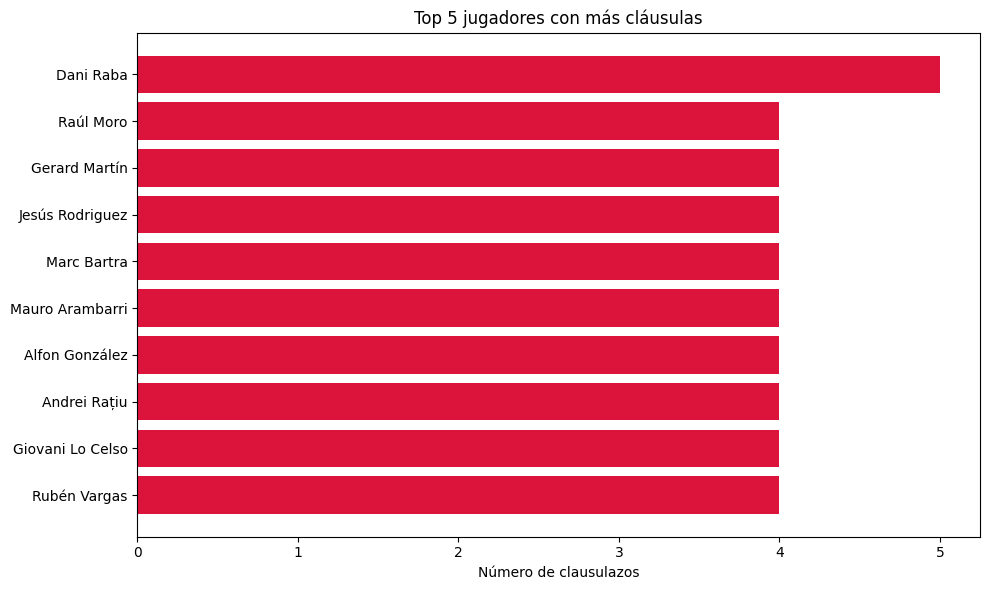

In [6]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            COUNT(*) AS clausulazos
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY clausulazos DESC
        LIMIT 10;
    """
    df_raw = pd.read_sql(query, conn)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(
    df_raw['nombre'] + ' ' + df_raw['apellido'],
    df_raw['clausulazos'],
    color='crimson'
)
plt.xlabel('Número de clausulazos')
plt.title('Top 5 jugadores con más cláusulas')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 6. Jugador con más traspasos

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\549213003.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transferencias = pd.read_sql(query, conn)


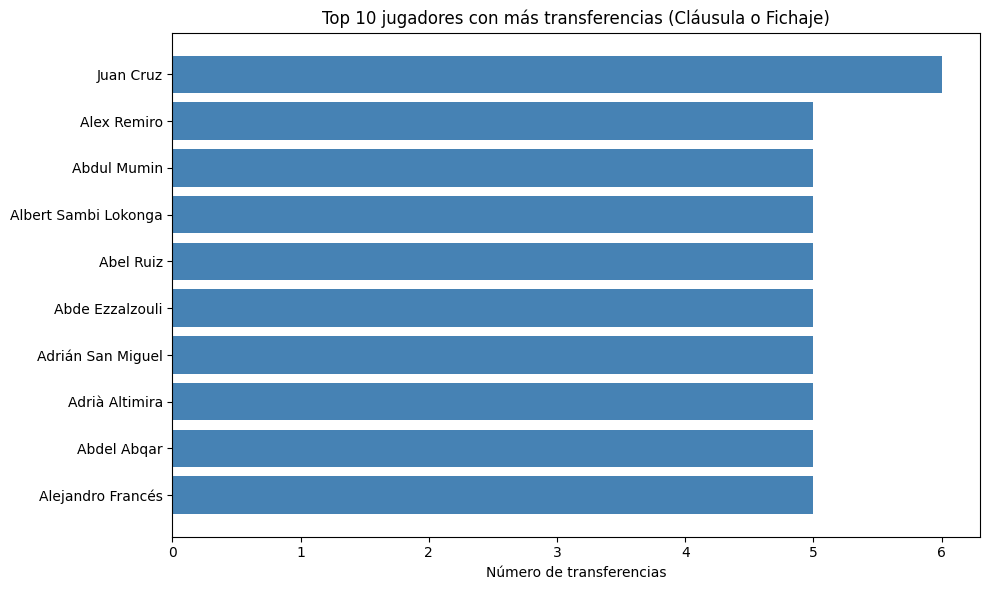

In [7]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            COUNT(*) AS total_transferencias
        FROM dbo.v_transferencias
        WHERE tipo_operacion IN ('Cláusula', 'Fichaje')
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY total_transferencias DESC
        LIMIT 10;
    """
    df_transferencias = pd.read_sql(query, conn)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(
    df_transferencias['nombre'] + ' ' + df_transferencias['apellido'],
    df_transferencias['total_transferencias'],
    color='steelblue'
)
plt.xlabel('Número de transferencias')
plt.title('Top 10 jugadores con más transferencias (Cláusula o Fichaje)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7. Jugador que más dinero ha movido (top 3)

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3725145374.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_podio = pd.read_sql(query, conn)


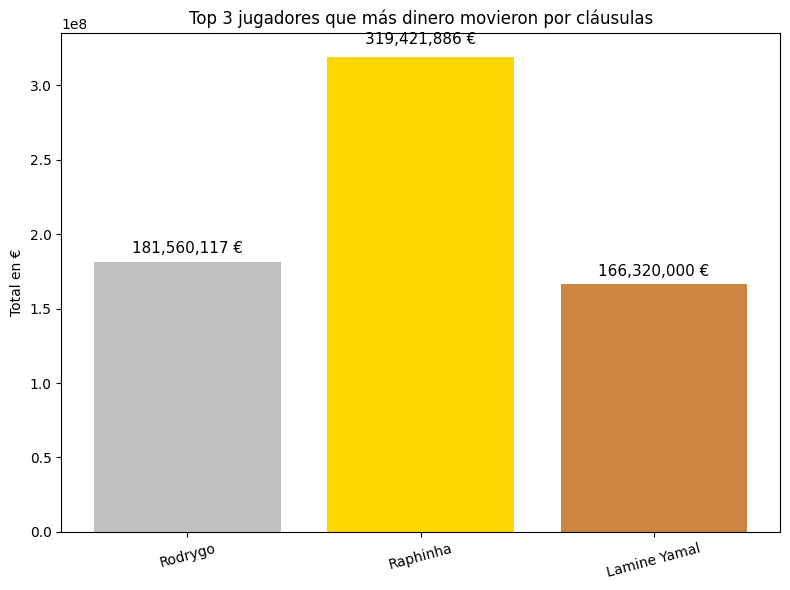

In [8]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            SUM(precio) AS total_dinero
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY total_dinero DESC
        LIMIT 3;
    """
    df_podio = pd.read_sql(query, conn)

# Crear columna con nombre completo, asegurando texto
df_podio['jugador'] = (df_podio['nombre'].fillna('') + ' ' + df_podio['apellido'].fillna('')).str.strip()

# Orden para estilo podio
df_podio = df_podio.sort_values('total_dinero', ascending=False).reset_index(drop=True)
df_podio = df_podio.loc[[1, 0, 2]] if len(df_podio) == 3 else df_podio  # solo si hay 3 jugadores

# Convertir a arrays
jugadores = df_podio['jugador'].astype(str).values
valores = df_podio['total_dinero'].astype(float).values

# Gráfico estilo podio
colors = ['silver', 'gold', 'peru']  # 🥈🥇🥉
plt.figure(figsize=(8, 6))
bars = plt.bar(jugadores, valores, color=colors[:len(jugadores)])

# Añadir valores encima
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + yval*0.02, f"{int(yval):,} €", 
             ha='center', va='bottom', fontsize=11)

plt.title("Top 3 jugadores que más dinero movieron por cláusulas")
plt.ylabel("Total en €")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 7. Jugador que más dinero ha movido (top 5)

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2182357760.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top5 = pd.read_sql(query, conn)


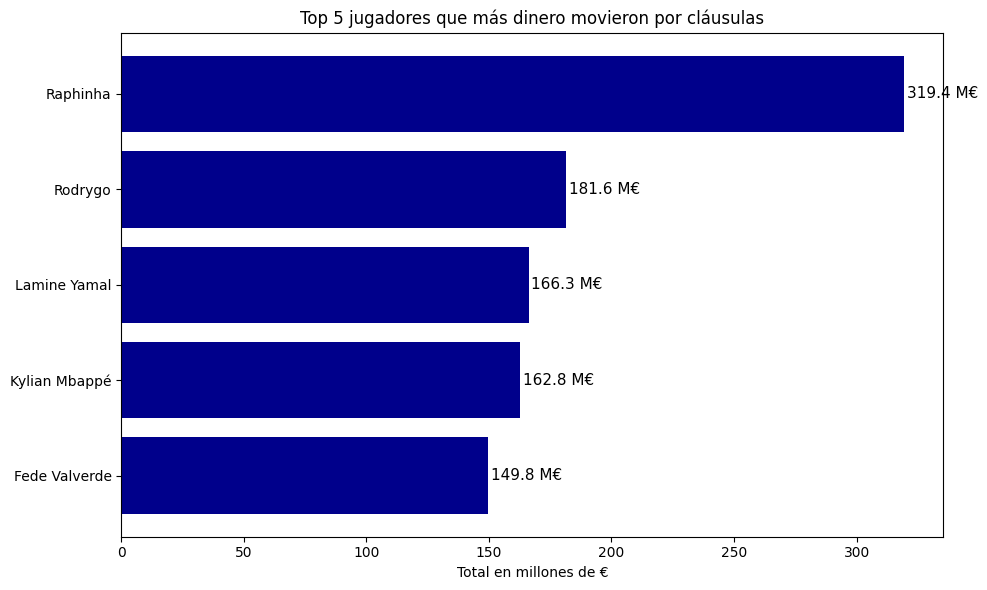

In [9]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            SUM(precio) AS total_dinero
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY total_dinero DESC
        LIMIT 5;
    """
    df_top5 = pd.read_sql(query, conn)

# Formatear datos
df_top5['jugador'] = (df_top5['nombre'].fillna('') + ' ' + df_top5['apellido'].fillna('')).str.strip()
df_top5['millones'] = (df_top5['total_dinero'] / 1_000_000).round(1)

# Gráfico horizontal
plt.figure(figsize=(10, 6))
bars = plt.barh(df_top5['jugador'], df_top5['millones'], color='darkblue')

# Etiquetas a la derecha de las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f} M€", va='center', fontsize=11)

plt.xlabel("Total en millones de €")
plt.title("Top 5 jugadores que más dinero movieron por cláusulas")
plt.gca().invert_yaxis()  # Poner al más caro arriba
plt.tight_layout()
plt.show()


# 8. Jugadores con mayor beneficio neto

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3304297273.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_jugadores = pd.read_sql(jugadores_sql, conn)
C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3304297273.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_jornadas = pd.read_sql(jornadas_sql, conn)
C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3304297273.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_once = pd.read_sql(once_ideal_sql, conn)
C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\330

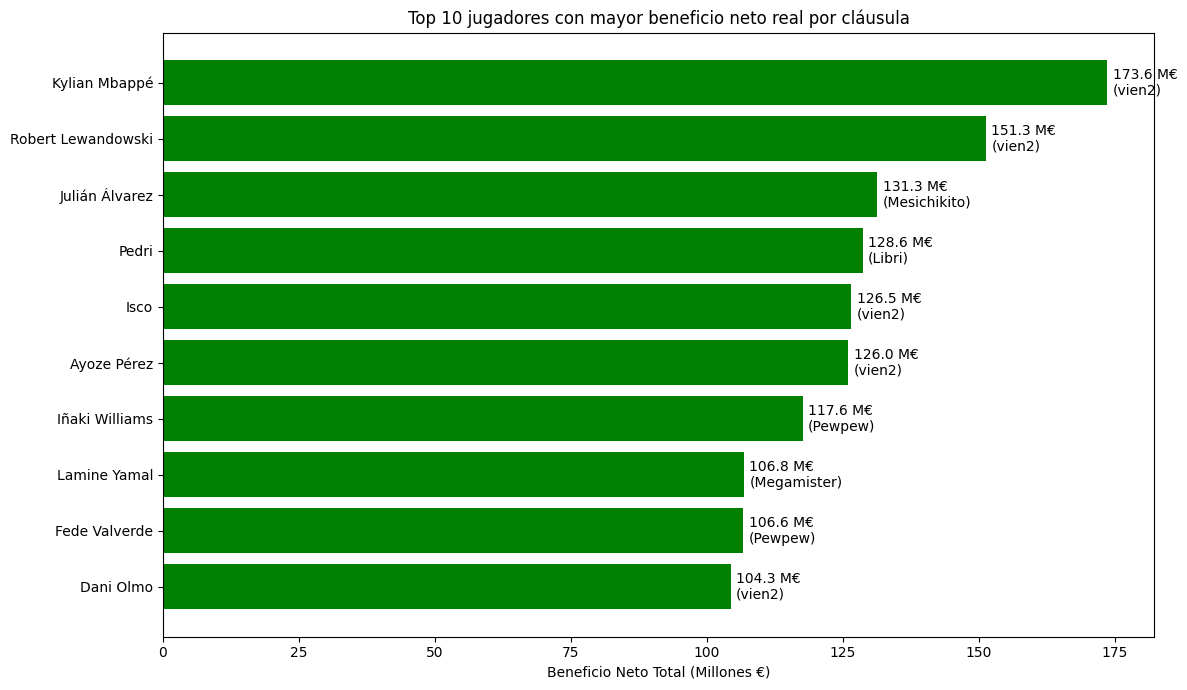

In [10]:
# Bonificaciones (en €)
BONUS_POR_PUNTO = 50000
BONUS_POR_GOL = 1000000
BONUS_POR_JORNADA = 500000
BONUS_ONCE_IDEAL = 500000
BONUS_CLASIFICACION = {
    1: 500000, 2: 600000, 3: 700000, 4: 800000, 5: 900000,
    6: 1000000, 7: 1100000, 8: 1200000, 9: 1300000, 10: 1400000,
    11: 1500000, 12: 1600000, 13: 1700000
}

# 1. Cargar jugadores fichados por cláusula
with conexion_db() as conn:
    jugadores_sql = """
        SELECT id_jugador, nombre, apellido, propietario, fecha, precio, clausula
        FROM dbo.v_datos_jugador
        WHERE clausula > precio AND fecha BETWEEN '2024-08-15' AND '2025-06-30'
    """
    df_jugadores = pd.read_sql(jugadores_sql, conn)

    # 2. Datos de rendimiento por jornada
    jornadas_sql = """
        SELECT id_jugador, jornada, puntuacion, eventos
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
    """
    df_jornadas = pd.read_sql(jornadas_sql, conn)
    df_jornadas['goles'] = df_jornadas['eventos'].fillna('').str.count(r'\bgol\b')

    # 3. Once ideal
    once_ideal_sql = """
        SELECT id_jugador, jornada
        FROM dbo.v_best_xi_jornadas
        WHERE temporada = '24/25'
    """
    df_once = pd.read_sql(once_ideal_sql, conn)

    # 4. Clasificación por jornada
    clasif_sql = """
        SELECT jornada, usuario, posicion
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df_clasif = pd.read_sql(clasif_sql, conn)

# 5. Calcular bonificaciones por jugador
resultados = []

for _, row in df_jugadores.iterrows():
    id_jugador = row['id_jugador']
    usuario = row['propietario']
    fecha_fichaje = row['fecha']
    precio = row['precio']
    clausula = row['clausula']
    nombre = (str(row['nombre']) if row['nombre'] else '').strip()
    apellido = (str(row['apellido']) if row['apellido'] else '').strip()
    nombre_completo = f"{nombre} {apellido}".strip()

    # Jornadas del jugador desde su fichaje
    jugador_jornadas = df_jornadas[df_jornadas['id_jugador'] == id_jugador]
    jornadas_disputadas = jugador_jornadas['jornada'].nunique()
    puntos = jugador_jornadas['puntuacion'].sum()
    goles = jugador_jornadas['goles'].sum()

    # Once ideal
    apariciones_once = df_once[df_once['id_jugador'] == id_jugador]['jornada'].nunique()

    # Bonificaciones por clasificación
    clasif_usuario = df_clasif[df_clasif['usuario'] == usuario]
    #bonus_clasificacion = sum(BONUS_CLASIFICACION.get(pos, 0) for pos in clasif_usuario['posicion'])

    # Calcular bonificación total
    bonificacion_total = (
        puntos * BONUS_POR_PUNTO +
        goles * BONUS_POR_GOL +
        jornadas_disputadas * BONUS_POR_JORNADA +
        apariciones_once * BONUS_ONCE_IDEAL 
        #+
        #bonus_clasificacion
    )

    beneficio_neto_total = clausula - precio + bonificacion_total

    resultados.append({
        'jugador': nombre_completo,
        'usuario': usuario,
        'beneficio_neto_total': beneficio_neto_total
    })

# 6. Crear DataFrame final y mostrar top 10
df_resultados = pd.DataFrame(resultados)
top10 = df_resultados.sort_values(by='beneficio_neto_total', ascending=False).head(10)

# 7. Graficar
plt.figure(figsize=(12, 7))
bars = plt.barh(top10['jugador'], top10['beneficio_neto_total'] / 1_000_000, color='green')

for i, bar in enumerate(bars):
    beneficio = top10.iloc[i]['beneficio_neto_total'] / 1_000_000
    usuario = top10.iloc[i]['usuario']
    plt.text(beneficio + 1, bar.get_y() + bar.get_height()/2,
             f"{beneficio:.1f} M€\n({usuario})", va='center', fontsize=10)

plt.xlabel("Beneficio Neto Total (Millones €)")
plt.title("Top 10 jugadores con mayor beneficio neto real por cláusula")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 9. Jugadores con menor beneficio neto

In [11]:
# Bonificaciones (en €)
BONUS_POR_PUNTO = 50000
BONUS_POR_GOL = 1000000
BONUS_POR_JORNADA = 500000
BONUS_ONCE_IDEAL = 500000
BONUS_CLASIFICACION = {
    1: 500000, 2: 600000, 3: 700000, 4: 800000, 5: 900000,
    6: 1000000, 7: 1100000, 8: 1200000, 9: 1300000, 10: 1400000,
    11: 1500000, 12: 1600000, 13: 1700000
}

with conexion_db() as conn:
    # 1. Jugadores fichados por cláusula
    jugadores_sql = """
        SELECT id_jugador, nombre, apellido, propietario, fecha, precio, clausula
        FROM dbo.v_datos_jugador
        WHERE clausula > precio AND fecha BETWEEN '2024-08-15' AND '2025-06-30'
    """
    df_jugadores = pd.read_sql(jugadores_sql, conn)

    # 2. Datos de jornada + fechas
    jornadas_sql = """
        SELECT id_jugador, jornada, puntuacion, eventos, f_carga::date as fecha_jornada
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
    """
    df_jornadas = pd.read_sql(jornadas_sql, conn)
    df_jornadas['goles'] = df_jornadas['eventos'].fillna('').str.count(r'\bgol\b')

    # 3. Once ideal
    once_ideal_sql = """
        SELECT id_jugador, jornada
        FROM dbo.v_best_xi_jornadas
        WHERE temporada = '24/25'
    """
    df_once = pd.read_sql(once_ideal_sql, conn)

    # 4. Clasificación por jornada
    clasif_sql = """
        SELECT jornada, usuario, posicion
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df_clasif = pd.read_sql(clasif_sql, conn)

# Mapeo jornada ↔ fecha mínima para filtrar correctamente
jornada_fecha_map = (
    df_jornadas[['jornada', 'fecha_jornada']]
    .dropna()
    .groupby('jornada')['fecha_jornada']
    .min()
    .to_dict()
)

# 5. Calcular bonificaciones reales por jugador
resultados = []

for _, row in df_jugadores.iterrows():
    id_jugador = row['id_jugador']
    usuario = row['propietario']
    fecha_fichaje = row['fecha']
    precio = row['precio']
    clausula = row['clausula']
    nombre = (str(row['nombre']) if row['nombre'] else '').strip()
    apellido = (str(row['apellido']) if row['apellido'] else '').strip()
    nombre_completo = f"{nombre} {apellido}".strip()

    # Determinar desde qué jornada contar (la primera con fecha igual o posterior al fichaje)
    jornada_fichaje = min(
        (j for j, f in jornada_fecha_map.items() if f >= fecha_fichaje),
        default=None
    )
    if jornada_fichaje is None:
        continue  # No hay jornadas posteriores al fichaje

    # --- Jornadas jugadas por el jugador desde el fichaje ---
    jugador_jornadas = df_jornadas[
        (df_jornadas['id_jugador'] == id_jugador) &
        (df_jornadas['jornada'] >= jornada_fichaje)
    ]
    jornadas_disputadas = jugador_jornadas['jornada'].nunique()
    puntos = jugador_jornadas['puntuacion'].sum()
    goles = jugador_jornadas['goles'].sum()

    # --- Apariciones en once ideal desde esa jornada ---
    apariciones_once = df_once[
        (df_once['id_jugador'] == id_jugador) &
        (df_once['jornada'] >= jornada_fichaje)
    ]['jornada'].nunique()

    # --- Clasificaciones del usuario desde esa jornada ---
    clasif_usuario = df_clasif[
        (df_clasif['usuario'] == usuario) &
        (df_clasif['jornada'] >= jornada_fichaje)
    ]
    bonus_clasificacion = sum(
        BONUS_CLASIFICACION.get(pos, 0) for pos in clasif_usuario['posicion']
    )

    # Calcular bonificación total
    bonificacion_total = (
        puntos * BONUS_POR_PUNTO +
        goles * BONUS_POR_GOL +
        jornadas_disputadas * BONUS_POR_JORNADA +
        apariciones_once * BONUS_ONCE_IDEAL +
        bonus_clasificacion
    )

    beneficio_neto_total = clausula - precio + bonificacion_total

    resultados.append({
        'jugador': nombre_completo,
        'usuario': usuario,
        'beneficio_neto_total': beneficio_neto_total
    })

# 6. Crear DataFrame final y graficar bottom 10
df_resultados = pd.DataFrame(resultados)

bottom10 = df_resultados.sort_values(by='beneficio_neto_total', ascending=True).head(10)

plt.figure(figsize=(12, 7))
bars = plt.barh(bottom10['jugador'], bottom10['beneficio_neto_total'] / 1_000_000, color='red')

for i, bar in enumerate(bars):
    beneficio = bottom10.iloc[i]['beneficio_neto_total'] / 1_000_000
    usuario = bottom10.iloc[i]['usuario']
    plt.text(beneficio + 1, bar.get_y() + bar.get_height()/2,
             f"{beneficio:.1f} M€\n({usuario})", va='center', fontsize=10)

plt.xlabel("Beneficio Neto Total (Millones €)")
plt.title("Top 10 jugadores con menor beneficio neto real por cláusula (ajustado a fecha de fichaje)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1673793408.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_jugadores = pd.read_sql(jugadores_sql, conn)
C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1673793408.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_jornadas = pd.read_sql(jornadas_sql, conn)
C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1673793408.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_once = pd.read_sql(once_ideal_sql, conn)
C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\167

TypeError: '>=' not supported between instances of 'str' and 'int'

# 10. Jugador con el clasulazo más alto

In [15]:
with conexion_db() as conn:
    clausulazo_sql = """
        select b.nombre,
            b.apellido,
            b.propietario,
            a.fecha_transferencia,
            a.precio,
            b.clausula,
            b.valor
            from dbo.v_transferencias a
            inner join dbo.v_datos_jugador b
            on a.id_jugador = b.id_jugador
            WHERE a.tipo_operacion = 'Cláusula'
            AND a.fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
            ORDER BY a.precio DESC
            LIMIT 1;
    """
    df_clausulazo = pd.read_sql(clausulazo_sql, conn)

# Mostrar el resultado
jugador = df_clausulazo.iloc[0]
print(f"💥 Clausulazo más alto:")
print(f"- Jugador: {jugador['nombre']} {jugador['apellido']}")
print(f"- Usuario: {jugador['propietario']}")
print(f"- Fecha: {jugador['fecha_transferencia']}")
print(f"- Precio pagado: {jugador['precio']:,.0f} €")
print(f"- Valor: {jugador['valor']:,.0f} €")
print(f"- Cláusula actual: {jugador['clausula']:,.0f} €")
print(f"- Diferencia (beneficio bruto): {jugador['clausula'] - jugador['precio']:,.0f} €")


💥 Clausulazo más alto:
- Jugador: None Raphinha
- Usuario: Mesichikito
- Fecha: 2025-04-06
- Precio pagado: 136,895,094 €
- Valor: 25,001,000 €
- Cláusula actual: 205,342,641 €
- Diferencia (beneficio bruto): 68,447,547 €


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2151650482.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_clausulazo = pd.read_sql(clausulazo_sql, conn)


# 11. Jugadore TOP en cada estadística

In [24]:
with conexion_db() as conn:
    query = """
        SELECT *
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# Lista de columnas que NO se deben analizar
no_relevantes = [
    'nombre', 'apellido', 'jornada', 'eventos', 'sancionolesion', 'temporada',
    'f_carga', 'id_jugador'
]

# Filtramos columnas numéricas relevantes
estadisticas_numericas = [
    col for col in df.columns
    if col not in no_relevantes and pd.api.types.is_numeric_dtype(df[col])
]

# DataFrame para almacenar los mejores en cada estadística
mejores = []

for col in estadisticas_numericas:
    max_idx = df[col].idxmax()
    fila = df.loc[max_idx]
    mejores.append({
        'estadística': col,
        'valor': fila[col],
        'jugador': f"{fila['nombre']} {fila['apellido']}".strip(),
        'jornada': fila['jornada']
    })

df_mejores = pd.DataFrame(mejores).sort_values(by='estadística')
# Mostrar en consola
display(df_mejores)


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3286924141.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,estadística,valor,jugador,jornada
5,asistencias_de_gol,3.0,Iñaki Williams,5
30,asistencias_esperadas,1.2,Iñaki Williams,12
4,balones_en_largo_precisos,23.0,Dominik Greif,11
3,balones_en_largo_totales,38.0,Marko Dmitrović,17
7,centros_precisos,7.0,Adnan Januzaj,9
6,centros_totales,20.0,Álvaro Tejero,11
21,despejes_por_alto,6.0,Marko Dmitrović,20
20,despejes_totales,21.0,Aridane Hernández,35
10,duelos_aereos_ganados,16.0,Vedat Muriqi,11
11,duelos_aereos_perdidos,12.0,Oli McBurnie,35


# 12. Evolución puntuación de jornadas por usuario

In [57]:
with conexion_db() as conn:
    query = """
        SELECT jornada, usuario, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# 2. Asegurar tipos
df['jornada'] = df['jornada'].astype(int)
df['puntos'] = df['puntos'].astype(int)

# 3. Crear gráfico interactivo de líneas
fig = px.line(
    df,
    x="jornada",
    y="puntos",
    color="usuario",
    markers=True,
    title="📈 Evolución de puntuaciones por jornada (Liga Mister)",
    labels={"jornada": "Jornada", "puntos": "Puntos", "usuario": "Usuario"},
    template="plotly_white"
)

# 4. Personalización: colores + visuales
fig.update_traces(line=dict(width=2))  # grosor de línea
fig.update_layout(
    hovermode="x unified",
    legend_title_text="Usuarios",
    width=1200,
    height=700,
    font=dict(size=14),
    margin=dict(t=80, b=40, r=10, l=10)
)

# 5. Exportar a HTML
fig.write_html("grafico_puntos_por_jornada.html")

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2529419267.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 13. Puntuaciones acumuladas por usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3506858370.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3506858370.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3506858370.py:39: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.

C:\Users\juan_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.



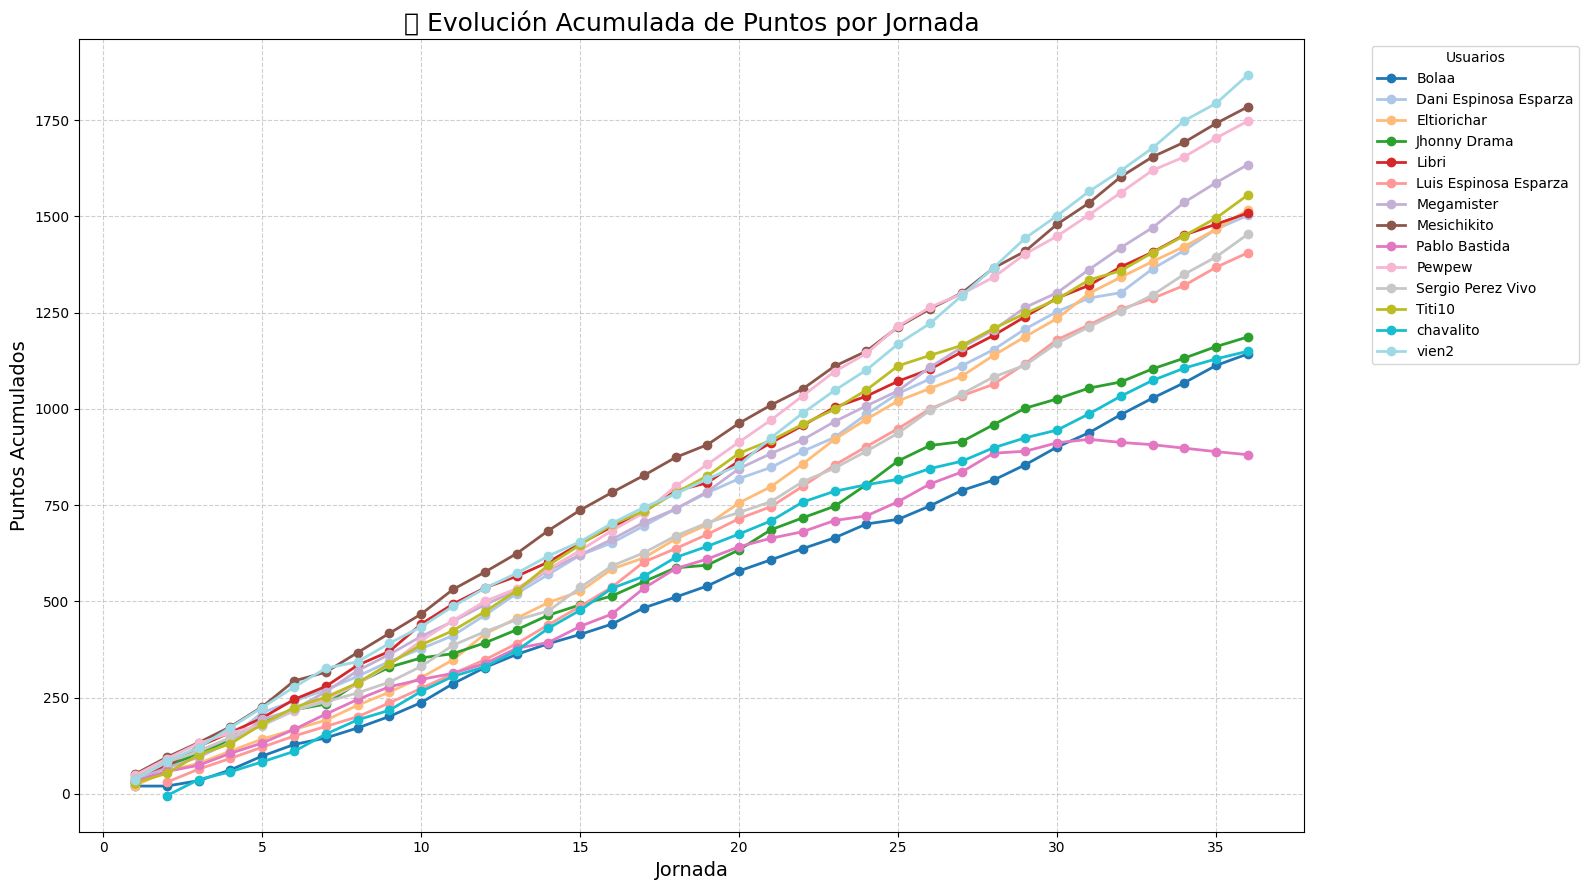

In [56]:
with conexion_db() as conn:
    query = """
        SELECT jornada, usuario, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# 2. Asegurar tipos correctos
df['jornada'] = df['jornada'].astype(int)
df['puntos'] = df['puntos'].astype(int)

# 3. Ordenar por usuario y jornada
df = df.sort_values(by=['usuario', 'jornada'])

# 4. Calcular puntos acumulados por usuario
df['puntos_acumulados'] = df.groupby('usuario')['puntos'].cumsum()

# 5. Pivot para líneas por usuario
pivot_df = df.pivot(index='jornada', columns='usuario', values='puntos_acumulados')
usuarios = pivot_df.columns
num_usuarios = len(usuarios)

# 6. Crear colores únicos por usuario
colormap = cm.get_cmap('tab20', num_usuarios)
colors = [colormap(i) for i in range(num_usuarios)]

# 7. Graficar
plt.figure(figsize=(16, 9))

for i, usuario in enumerate(usuarios):
    plt.plot(pivot_df.index, pivot_df[usuario], label=usuario, marker='o', linewidth=2, color=colors[i])

plt.title("📈 Evolución Acumulada de Puntos por Jornada", fontsize=18)
plt.xlabel("Jornada", fontsize=14)
plt.ylabel("Puntos Acumulados", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Usuarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 14. Radar chart ofensivo vs defensivo para un jugador

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1521264371.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



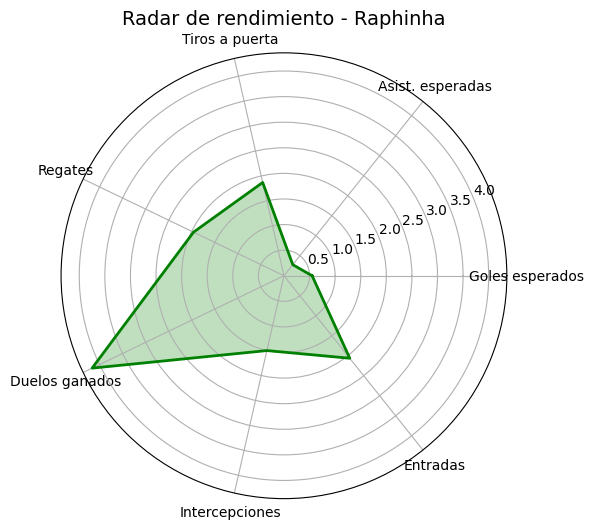

In [35]:
jugador_objetivo = "Raphinha"

with conexion_db() as conn:
    query = f"""
        SELECT *
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
          AND (apellido = '{jugador_objetivo}' OR CONCAT(COALESCE(nombre, ''), ' ', COALESCE(apellido, '')) = '{jugador_objetivo}')
    """
    df = pd.read_sql(query, conn)

# Asegurar que hay datos
if df.empty:
    print(f"No se encontraron registros para {jugador_objetivo}")
else:
    # Campos a incluir en el radar
    stats = {
        'Goles esperados': 'goles_esperados',
        'Asist. esperadas': 'asistencias_esperadas',
        'Tiros a puerta': 'tiros_a_puerta',
        'Regates': 'regates_completados',
        'Duelos ganados': 'duelos_ganados',
        'Intercepciones': 'intercepciones',
        'Entradas': 'entradas_totales'
    }

    # Calcular promedio por estadística
    valores = [df[col].mean() for col in stats.values()]
    labels = list(stats.keys())

    # Preparar radar chart
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    valores += valores[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, valores, color='green', linewidth=2)
    ax.fill(angles, valores, color='green', alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)

    # Construir nombre completo para título
    nombre_titulo = f"{df['nombre'].iloc[0] or ''} {df['apellido'].iloc[0]}".strip()
    ax.set_title(f"Radar de rendimiento - {nombre_titulo}", size=14)

    plt.tight_layout()
    plt.show()

# 15. Ranking de regularidad (mejor media puntuación)

In [38]:
with conexion_db() as conn:
    query = """
        SELECT 
            j.id_jugador,
            j.nombre,
            j.apellido,
            g.propietario,
            AVG(j.puntuacion) AS media_puntos,
            COUNT(*) AS partidos
        FROM dbo.v_datos_jornadas j
        JOIN dbo.v_datos_jugador g ON j.id_jugador = g.id_jugador
        WHERE j.temporada = '24/25' AND j.puntuacion IS NOT NULL
        GROUP BY j.id_jugador, j.nombre, j.apellido, g.propietario
        HAVING COUNT(*) >= 5
        ORDER BY media_puntos DESC
        LIMIT 10
    """
    df_regularidad = pd.read_sql(query, conn)

# Construir nombre completo
df_regularidad['jugador'] = (df_regularidad['nombre'].fillna('') + ' ' + df_regularidad['apellido'].fillna('')).str.strip()

# Ordenar columnas
df_regularidad = df_regularidad[['jugador', 'propietario', 'media_puntos', 'partidos']]

# Mostrar bonito
print(df_regularidad.to_string(index=False))


           jugador propietario  media_puntos  partidos
     Kylian Mbappé       vien2      8.866667        30
          Raphinha Mesichikito      8.382353        34
              Isco       vien2      7.800000        20
Robert Lewandowski       vien2      7.741935        31
      Lamine Yamal  Megamister      7.727273        33
      Oihan Sancet Eltiorichar      7.629630        27
             Pedri       Libri      7.485714        35
         Dani Olmo       vien2      7.434783        23
       Ayoze Pérez       vien2      7.379310        29
        Alex Baena Mesichikito      7.200000        30


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2261645813.py:18: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 16. Mejor jornada de cada jugador

In [43]:
with conexion_db() as conn:
    query = """
        SELECT nombre, apellido, jornada, puntuacion
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
        and sancionolesion not in ('No jugó la jornada', 'No convocado')
    """
    df = pd.read_sql(query, conn)

df['jugador'] = (df['nombre'].fillna('') + ' ' + df['apellido'].fillna('')).str.strip()
mejor_jornada = df.sort_values(['jugador', 'puntuacion'], ascending=[True, False])
mejor_jornada = mejor_jornada.drop_duplicates('jugador')

print(mejor_jornada[['jugador', 'jornada', 'puntuacion']].sort_values(by='puntuacion', ascending=False).head(10))


                  jugador  jornada  puntuacion
11328   Alexander Sørloth       35        25.0
7116         Oihan Sancet       23        23.0
5812          Kike García       20        21.0
6438        Kylian Mbappé       21        21.0
5188        Thierno Barry       18        21.0
2537   Robert Lewandowski        9        21.0
620              Raphinha        4        21.0
3903      Vinícius Júnior       13        20.0
6767         Fermín López       21        20.0
1321           Javi Puado        5        20.0


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\723815745.py:8: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 17. Jugador con más apariciones en el once ideal

In [44]:
with conexion_db() as conn:
    query = """
        SELECT id_jugador, nombre, COUNT(*) as veces_en_once
        FROM dbo.v_best_xi_jornadas
        WHERE temporada = '24/25'
        GROUP BY id_jugador, nombre
        ORDER BY veces_en_once DESC
        LIMIT 10
    """
    df_once = pd.read_sql(query, conn)

print(df_once)


   id_jugador              nombre  veces_en_once
0       58954       Kylian Mbappe             10
1       48657            Raphinha              9
2       48684  Robert Lewandowski              9
3       59415           Dani Olmo              7
4       22547               Pedri              7
5       29166         Joan Garcia              7
6       53114     Jude Bellingham              6
7       14789        Oihan Sancet              6
8       18004        Ante Budimir              6
9       24739      Oscar Mingueza              5


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2492212660.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 18. Eficiencia goleadora (goles / tiros a puerta)

In [49]:
with conexion_db() as conn:
    query = """
        SELECT id_jugador, nombre, apellido, eventos, tiros_a_puerta
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25' AND tiros_a_puerta IS NOT NULL
    """
    df = pd.read_sql(query, conn)

# Extraer goles desde la columna 'eventos'
df['goles'] = df['eventos'].fillna('').str.count(r'\bgol\b')
df['jugador'] = (df['nombre'].fillna('') + ' ' + df['apellido'].fillna('')).str.strip()

# Agrupar por jugador
agrupado = df.groupby(['id_jugador', 'jugador']).agg({
    'goles': 'sum',
    'tiros_a_puerta': 'sum',
    'eventos': 'count'  # para saber cuántas jornadas tiene
}).reset_index()

# Filtrar con mínimo de tiros a puerta para ser relevante
agrupado = agrupado[agrupado['tiros_a_puerta'] >= 5]

# Calcular eficiencia
agrupado['eficiencia'] = agrupado['goles'] / agrupado['tiros_a_puerta']

# Ordenar
eficientes = agrupado.sort_values(by='eficiencia', ascending=False).head(10)

# Mostrar
print(eficientes[['jugador', 'goles', 'tiros_a_puerta', 'eficiencia']].to_string(index=False))


          jugador  goles  tiros_a_puerta  eficiencia
   Juanlu Sánchez      4               5    0.800000
    Daniel Vivian      4               5    0.800000
Roberto Fernández      6               8    0.750000
       Umar Sadiq      5               7    0.714286
  Leandro Cabrera      4               6    0.666667
       Pathé Ciss      4               6    0.666667
   Martin Valjent      3               5    0.600000
      Ayoze Pérez     18              30    0.600000
     Oihan Sancet     12              20    0.600000
   Seydouba Cisse      3               5    0.600000


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1456666644.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 19. Efectividad total de tiro

In [50]:
with conexion_db() as conn:
    query = """
        SELECT id_jugador, nombre, apellido, eventos, tiros_a_puerta, tiros_fuera
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
          AND (tiros_a_puerta IS NOT NULL OR tiros_fuera IS NOT NULL)
    """
    df = pd.read_sql(query, conn)

# Calcular goles desde eventos
df['goles'] = df['eventos'].fillna('').str.count(r'\bgol\b')
df['jugador'] = (df['nombre'].fillna('') + ' ' + df['apellido'].fillna('')).str.strip()

# Reemplazar NaN por 0 para suma de tiros
df['tiros_a_puerta'] = df['tiros_a_puerta'].fillna(0)
df['tiros_fuera'] = df['tiros_fuera'].fillna(0)

# Agrupar por jugador
agrupado = df.groupby(['id_jugador', 'jugador']).agg({
    'goles': 'sum',
    'tiros_a_puerta': 'sum',
    'tiros_fuera': 'sum'
}).reset_index()

# Calcular total de tiros y eficiencia
agrupado['tiros_totales'] = agrupado['tiros_a_puerta'] + agrupado['tiros_fuera']
agrupado = agrupado[agrupado['tiros_totales'] >= 5]  # mínimo de tiros para ser relevante
agrupado['efectividad_total'] = agrupado['goles'] / agrupado['tiros_totales']

# Ordenar
ranking = agrupado.sort_values(by='efectividad_total', ascending=False).head(10)

# Mostrar
print(ranking[['jugador', 'goles', 'tiros_totales', 'efectividad_total']].to_string(index=False))


          jugador  goles  tiros_totales  efectividad_total
    Aitor Paredes      3            5.0           0.600000
      Pablo Torre      3            6.0           0.500000
Roberto Fernández      6           13.0           0.461538
   Juanlu Sánchez      4           10.0           0.400000
       Álex Muñoz      3            8.0           0.375000
     Rubén García      5           14.0           0.357143
   Martin Valjent      3            9.0           0.333333
       Pere Milla      2            6.0           0.333333
     Oihan Sancet     12           36.0           0.333333
 Javier Rodríguez      3            9.0           0.333333


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2852531100.py:8: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 20. Evolución valor equipo

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1507975526.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1507975526.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\1507975526.py:33: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.

C:\Users\juan_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.



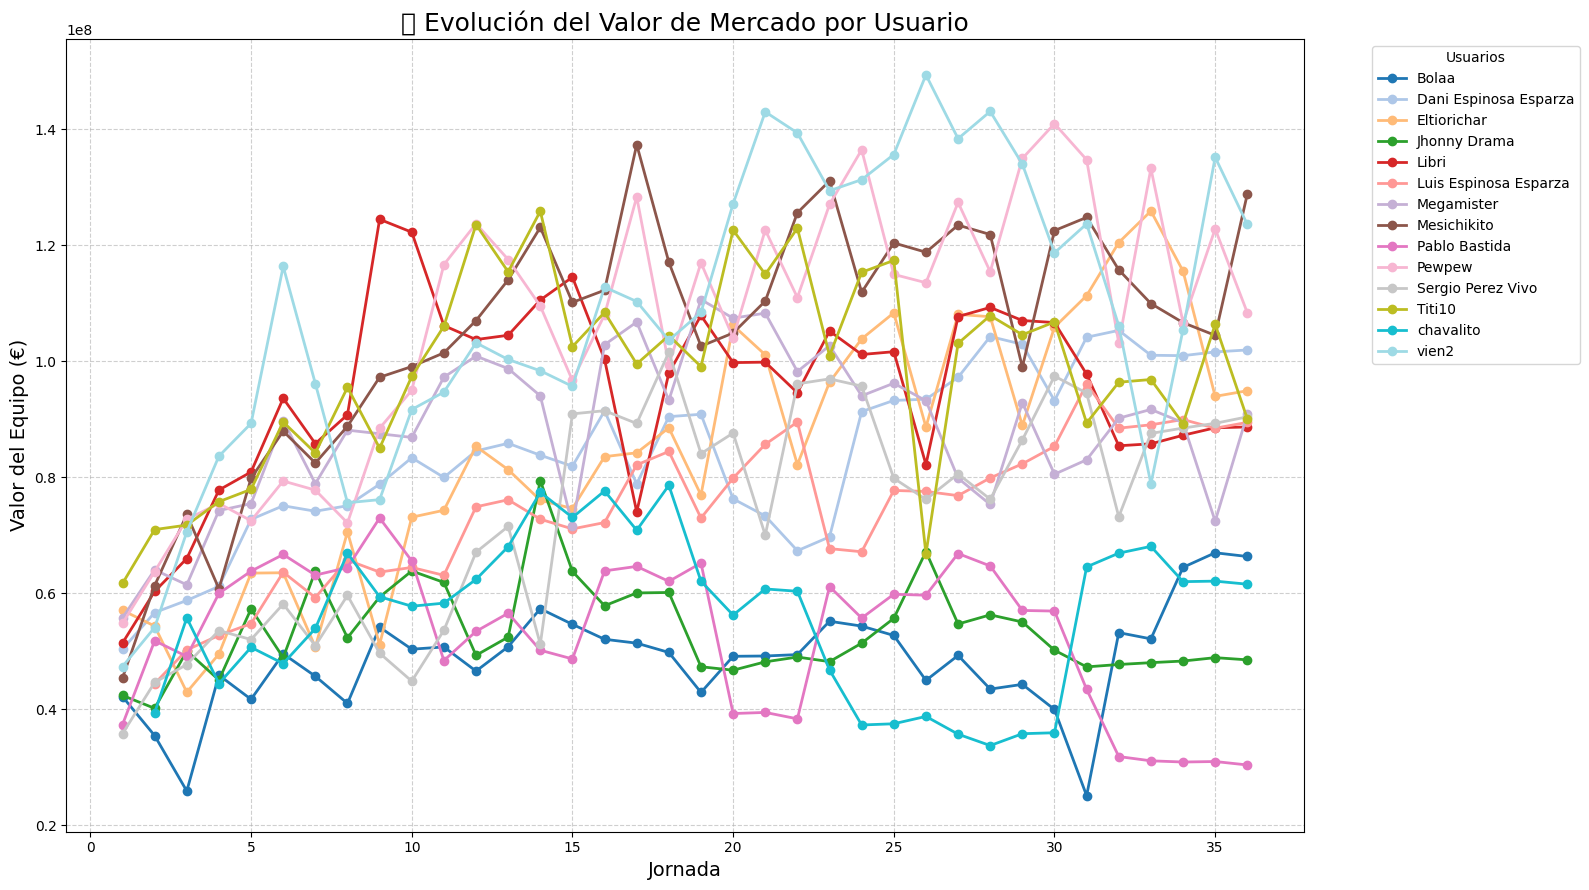

In [55]:
with conexion_db() as conn:
    query = """
        SELECT jornada, usuario, valor_equipo
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# 2. Convertir tipos
df['jornada'] = df['jornada'].astype(int)
df['valor_equipo'] = df['valor_equipo'].astype(float)

# 3. Pivot para líneas por usuario
pivot_df = df.pivot(index='jornada', columns='usuario', values='valor_equipo')
usuarios = pivot_df.columns
num_usuarios = len(usuarios)

# 4. Colores únicos por usuario
colormap = cm.get_cmap('tab20', num_usuarios)
colors = [colormap(i) for i in range(num_usuarios)]

# 5. Graficar
plt.figure(figsize=(16, 9))

for i, usuario in enumerate(usuarios):
    plt.plot(pivot_df.index, pivot_df[usuario], label=usuario, marker='o', linewidth=2, color=colors[i])

plt.title("💸 Evolución del Valor de Mercado por Usuario", fontsize=18)
plt.xlabel("Jornada", fontsize=14)
plt.ylabel("Valor del Equipo (€)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Usuarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 21. ¿Quién ha terminado más veces primero?

In [58]:
with conexion_db() as conn:
    query = """
        SELECT usuario, COUNT(*) AS veces_primero
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25' AND posicion = 1
        GROUP BY usuario
        ORDER BY veces_primero DESC
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


              usuario  veces_primero
                vien2             10
Dani Espinosa Esparza              5
          Mesichikito              5
               Pewpew              4
          Eltiorichar              4
                Libri              3
           Megamister              2
        Pablo Bastida              1
    Sergio Perez Vivo              1
               Titi10              1


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2587310815.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 22. Mayor media de puntos por jornada

In [59]:
with conexion_db() as conn:
    query = """
        SELECT usuario, AVG(puntos) AS media_puntos, COUNT(*) AS jornadas
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
        GROUP BY usuario
        HAVING COUNT(*) >= 5
        ORDER BY media_puntos DESC
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


              usuario  media_puntos  jornadas
                vien2     51.888889        36
          Mesichikito     49.583333        36
               Pewpew     48.555556        36
           Megamister     45.416667        36
               Titi10     43.222222        36
          Eltiorichar     42.138889        36
                Libri     41.916667        36
Dani Espinosa Esparza     41.750000        36
    Sergio Perez Vivo     40.388889        36
Luis Espinosa Esparza     40.171429        35
         Jhonny Drama     32.972222        36
            chavalito     32.857143        35
                Bolaa     31.750000        36
        Pablo Bastida     24.472222        36


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2891315632.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 23. Mejor jornada

In [60]:
with conexion_db() as conn:
    query = """
        SELECT usuario, jornada, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
        ORDER BY puntos DESC
        LIMIT 1
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


usuario  jornada  puntos
  vien2       29      77


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\2668635103.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 24. Peor jornada

In [61]:
with conexion_db() as conn:
    query = """
        SELECT usuario, jornada, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
        ORDER BY puntos asc
        LIMIT 1
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


      usuario  jornada  puntos
Pablo Bastida       34      -9


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3951790482.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 25. Relación entre puntos y valor del equipo

C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\3652622789.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



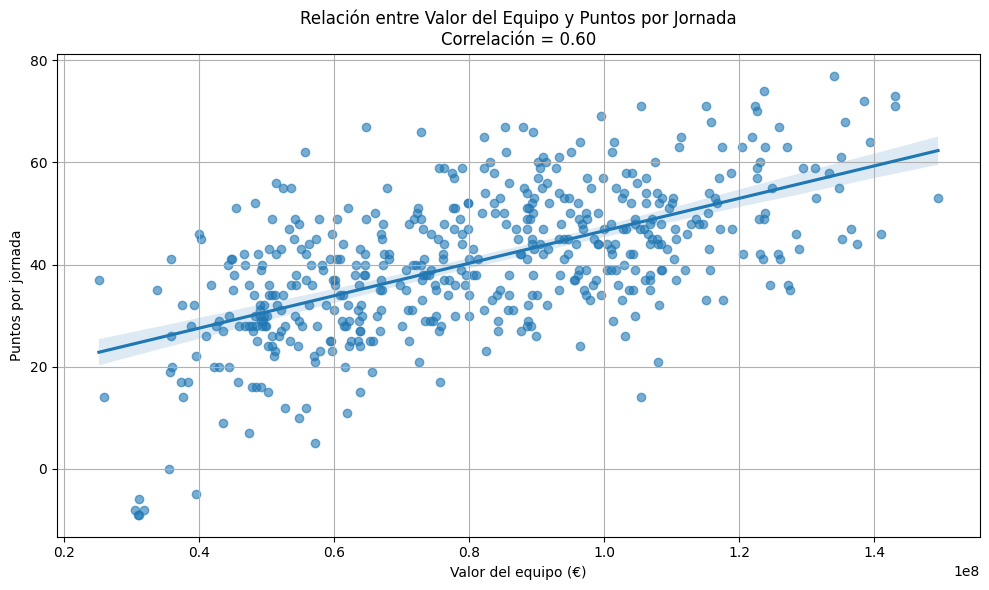

In [62]:
with conexion_db() as conn:
    query = """
        SELECT usuario, puntos, valor_equipo
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# Asegurar tipos correctos
df['valor_equipo'] = df['valor_equipo'].astype(float)

# Calcular correlación
correlacion = df['puntos'].corr(df['valor_equipo'])

# Scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x="valor_equipo", y="puntos", scatter_kws={'alpha': 0.6})
plt.title(f"Relación entre Valor del Equipo y Puntos por Jornada\nCorrelación = {correlacion:.2f}")
plt.xlabel("Valor del equipo (€)")
plt.ylabel("Puntos por jornada")
plt.grid(True)
plt.tight_layout()
plt.show()

# 26. Usuarios con más ganancias y pérdidas en cláusulas

In [64]:
def formatear_millones(valor):
    return f"{valor / 1_000_000:,.1f} M€".replace(",", ".")

with conexion_db() as conn:
    query = """
        SELECT tipo_operacion, usuario_origen, usuario_destino, precio
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
    """
    df = pd.read_sql(query, conn)

# Sumar lo ganado y perdido por usuario
ganado = df.groupby('usuario_origen')['precio'].sum().reset_index(name='ganado')
perdido = df.groupby('usuario_destino')['precio'].sum().reset_index(name='perdido')

# Unir por usuario
balance = pd.merge(ganado, perdido, left_on='usuario_origen', right_on='usuario_destino', how='outer')
balance['usuario'] = balance['usuario_origen'].combine_first(balance['usuario_destino'])
balance = balance.fillna(0)

# Calcular balance neto
balance['balance_clausulas'] = balance['ganado'] - balance['perdido']

# Seleccionar columnas y ordenar
balance_final = balance[['usuario', 'ganado', 'perdido', 'balance_clausulas']].sort_values(by='balance_clausulas', ascending=False)

# Formatear columnas en millones
for col in ['ganado', 'perdido', 'balance_clausulas']:
    balance_final[col] = balance_final[col].apply(formatear_millones)

# Mostrar resultados
print("🟢 Usuarios que más ganaron en cláusulas:\n")
print(balance_final.head(5).to_string(index=False))

print("\n🔴 Usuarios que más perdieron en cláusulas:\n")
print(balance_final.tail(5).sort_values(by='balance_clausulas').to_string(index=False))

🟢 Usuarios que más ganaron en cláusulas:

      usuario   ganado  perdido balance_clausulas
       Pewpew 603.5 M€ 407.3 M€          196.2 M€
        vien2 679.0 M€ 559.7 M€          119.3 M€
Pablo Bastida 212.1 M€ 147.4 M€           64.7 M€
       Titi10 618.6 M€ 585.6 M€           33.0 M€
  Eltiorichar 594.6 M€ 562.8 M€           31.8 M€

🔴 Usuarios que más perdieron en cláusulas:

              usuario   ganado  perdido balance_clausulas
Dani Espinosa Esparza 309.9 M€ 415.4 M€         -105.5 M€
           Megamister 554.3 M€ 669.9 M€         -115.6 M€
         Jhonny Drama 197.0 M€ 358.1 M€         -161.1 M€
Luis Espinosa Esparza 443.3 M€ 472.5 M€          -29.2 M€
    Sergio Perez Vivo 561.3 M€ 604.5 M€          -43.2 M€


C:\Users\juan_\AppData\Local\Temp\ipykernel_3244\83764041.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [65]:
conn.close()